In [181]:
import pywt # type: ignore
from tsai.all import * # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
from contextlib import contextmanager
import numpy as np # type: ignore
from sklearn.linear_model import LinearRegression # type: ignore
from pmdarima.arima import auto_arima # type: ignore
from sklearn.model_selection import train_test_split # type: ignore

# Mudar o diretório de trabalho
# Útil para acessar outras pastas com os.listdir() e afins
@contextmanager
def cwd(path: str) -> None:
    """path = Caminho do diretório de trabalho"""
    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

# Função para decompor a série temporal
def wavelet_decompose(data, wavelet='haar',level=2):
    """ data = Série temporal
        wavelet = Wavelet a ser usada
        level = Nível de decomposição
        """
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs

# Função para previsão usando auto_arima para encontrar o melhor modelo
def forecast_ar1(series,new_data,m=7):
    """ series = Série temporal
        new_data = Novos dados para atualizar o modelo
        steps = Número de passos para prever
        """
    arima_model = auto_arima(series,
            start_p=3, start_q=3, d=None, max_p=10, max_q=10, max_d=1,
            start_P=3, start_Q=3, D=None, max_P=5, max_Q=5, max_D=1, max_order=None,
            seasonal=True, m=m, trace=True, error_action='ignore',
            suppress_warnings=True, stepwise=True,information_criterion='aicc'
        )
    lista_previsoes = []
    for j in range(new_data.shape[0]): # Atualizar o modelo e prever
        # Tentei simular uma estrutura que atualiza o modelo, a partir de um x_test, e prevê os próximos 8 passos
        arima_model = arima_model.update(new_data[j, 0]) # Esse código pega cada observação de x_test, que contém 8 passos, e atualiza o modelo
        previsao = arima_model.predict(n_periods=8) # Essa parte prevê os próximos 8 passos
        lista_previsoes.append(previsao) # Adiciona os 8 passos previstos à lista
    forecast = np.array(lista_previsoes)
    return arima_model, forecast

# Inicializar e treinar a rede neural
def forecast_ann(X, y,splits, X_test, name, model = LSTMPlus, epochs=200):
    """ X = Matriz de features (n° de observações, características, comprimento da série temporal)
        y = Variável target (n° de observações, comprimento da série temporal)
        splits = Índices de treino e validação
        X_test = Matriz de features de teste (n° de observações, características, comprimento da série temporal)
        name = Nome do modelo
        model = Arquitetura da rede neural. Mais informações em https://timeseriesai.github.io/tsai/
        epochs = Número de épocas
        """
    learn = TSForecaster(X, y,splits=splits, arch=model, metrics=[mae, rmse], batch_tfms=TSStandardize(), tfms=[None, [TSForecasting()]], loss_func=HuberLoss(delta=1, reduction='mean')) # type: ignore
    with ContextManagers([learn.no_logging(), learn.no_bar()]):
        lr = learn.lr_find() # Achar o melhor learning rate pro modelo, método da biblioteca fastai
        learn.fit_one_cycle(epochs, lr_max=lr.valley)
        print(f'Métricas de Treinamento para {name}')
        display(pd.Series(learn.recorder.values[-1], index=learn.recorder.metric_names[1:5],name=name))
        raw_preds, _, _ = learn.get_X_preds(X_test)
        return raw_preds


# Carregar os dados
with cwd('./gpp_novo_2002_2021/'):
    csvs = sorted(os.listdir()) # Lista com os arquivos .csv
    dados = []
    for csv in csvs:
        region = csv.split('_')[1] # Nome da região
        df = pd.read_csv(csv, index_col='index', date_format='index').rename(columns={'GPP': region})
        df.index = pd.to_datetime(df.index)
        df = df.resample('D').mean() # Resample para preencher os dias faltantes e acrescentar frequência diária
        dados.append(df)
    df = pd.concat(dados, axis=1)

In [146]:
# Decomposição e previsão no Peru. Favor testar em outras regiões.
peru = df['peru'].copy()

peru_train, peru_test = train_test_split(peru, test_size=0.2, shuffle=False)
cA5_train, cD5_train, cD4_train, cD3_train, cD2_train, cD1_train = wavelet_decompose(peru_train, wavelet='haar',level=5)

cA5_test, cD5_test, cD4_test, cD3_test, cD2_test, cD1_test = wavelet_decompose(peru_test, wavelet='haar',level=5)

In [147]:
def create_sliding_windows(data, window_size=8, horizon=8):
    return SlidingWindow(window_size, horizon=horizon, stride=None, seq_first=True)(data) # type: ignore

# Criando janelas deslizantes para cada componente
window_size = 8
horizon = 8

In [148]:
# Teste especificamente do Arima
# Dividi em X e Y para utilizar o método .update no eixo X e prever com o tamanho do eixo Y
# Tentei "simular" predições que precisam de uma atualização constante do modelo
X_train_cA5, y_train_cA5 = create_sliding_windows(cA5_train, window_size=window_size, horizon=horizon)

# Treinamento
X_train_cD5, y_train_cD5 = create_sliding_windows(cD5_train, window_size=window_size, horizon=horizon)
X_train_cD4, y_train_cD4 = create_sliding_windows(cD4_train, window_size=window_size, horizon=horizon)
X_train_cD3, y_train_cD3 = create_sliding_windows(cD3_train, window_size=window_size, horizon=horizon)
X_train_cD2, y_train_cD2 = create_sliding_windows(cD2_train, window_size=window_size, horizon=horizon)
X_train_cD1, y_train_cD1 = create_sliding_windows(cD1_train, window_size=window_size, horizon=horizon)

# Teste
X_test_cA5, y_test_cA5 = create_sliding_windows(cA5_test, window_size=window_size, horizon=horizon)
X_test_cD5, y_test_cD5 = create_sliding_windows(cD5_test, window_size=window_size, horizon=horizon)
X_test_cD4, y_test_cD4 = create_sliding_windows(cD4_test, window_size=window_size, horizon=horizon)
X_test_cD3, y_test_cD3 = create_sliding_windows(cD3_test, window_size=window_size, horizon=horizon)
X_test_cD2, y_test_cD2 = create_sliding_windows(cD2_test, window_size=window_size, horizon=horizon)
X_test_cD1, y_test_cD1 = create_sliding_windows(cD1_test, window_size=window_size, horizon=horizon)

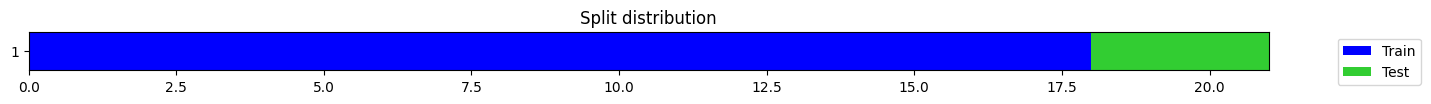

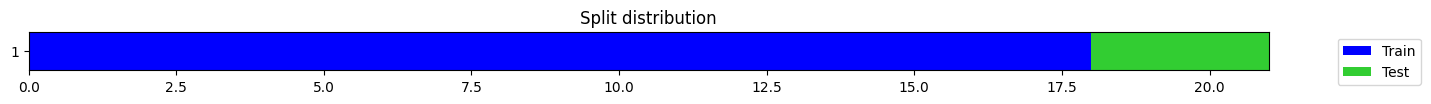

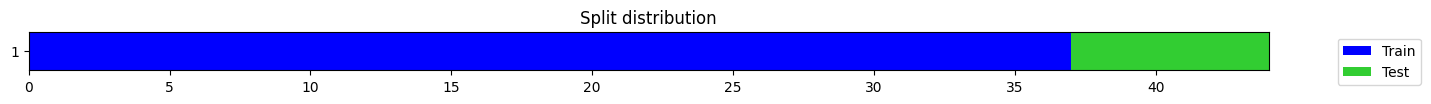

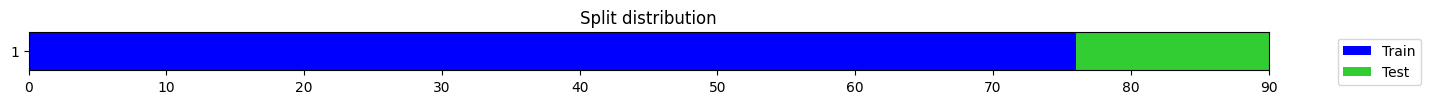

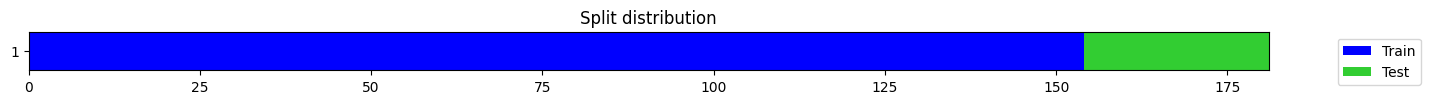

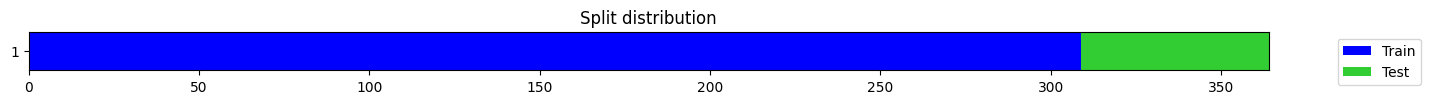

In [149]:
# Dividindo em treino e validação para a rede neural
splits_train_val_cA5 = TSSplitter(valid_size=0.15)(y_train_cA5) # type: ignore
splits_train_val_cD5 = TSSplitter(valid_size=0.15)(y_train_cD5) # type: ignore
splits_train_val_cD4 = TSSplitter(valid_size=0.15)(y_train_cD4) # type: ignore
splits_train_val_cD3 = TSSplitter(valid_size=0.15)(y_train_cD3) # type: ignore
splits_train_val_cD2 = TSSplitter(valid_size=0.15)(y_train_cD2) # type: ignore
splits_train_val_cD1 = TSSplitter(valid_size=0.15)(y_train_cD1) # type: ignore

In [175]:
cA5_train.shape

(183,)

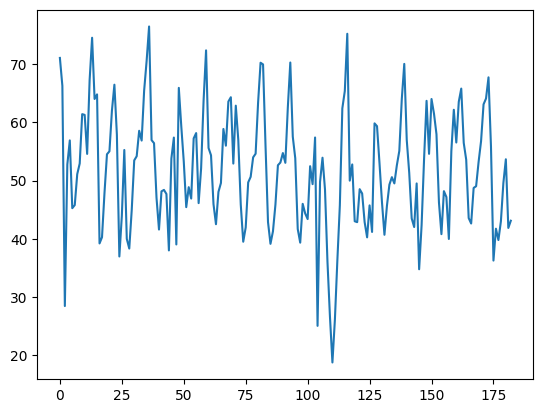

In [150]:
plt.plot(cA5_train)

In [188]:
# Prevendo com o melhor modelo ARIMA encontrado
arima_model, a5_forecast = forecast_ar1(cA5_train,new_data=X_test_cA5,m=10)

Performing stepwise search to minimize aicc
 ARIMA(3,0,3)(3,0,3)[10] intercept   : AICC=inf, Time=4.55 sec
 ARIMA(0,0,0)(0,0,0)[10] intercept   : AICC=1373.421, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[10] intercept   : AICC=1307.403, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[10] intercept   : AICC=1315.826, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[10]             : AICC=1972.919, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[10] intercept   : AICC=1306.855, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[10] intercept   : AICC=1307.449, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[10] intercept   : AICC=1310.031, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[10] intercept   : AICC=1305.927, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[10] intercept   : AICC=1306.907, Time=0.41 sec
 ARIMA(2,0,0)(0,0,1)[10] intercept   : AICC=1306.961, Time=0.12 sec
 ARIMA(2,0,0)(1,0,1)[10] intercept   : AICC=1309.042, Time=0.56 sec
 ARIMA(3,0,0)(0,0,0)[10] intercept   : AICC=1305.966, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[10] intercept   : AICC=1301.481, Time=0.25 sec
 ARIMA(2,

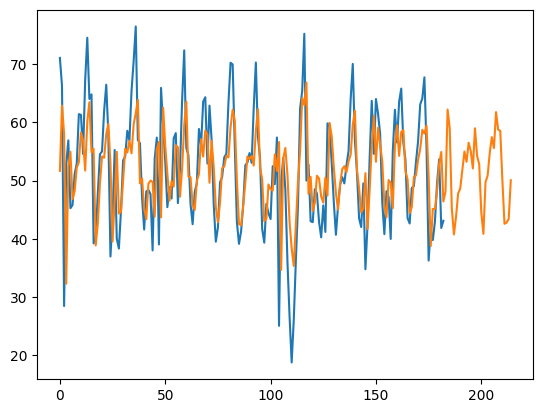

In [189]:
plt.plot(cA5_train)
plt.plot(arima_model.predict_in_sample())

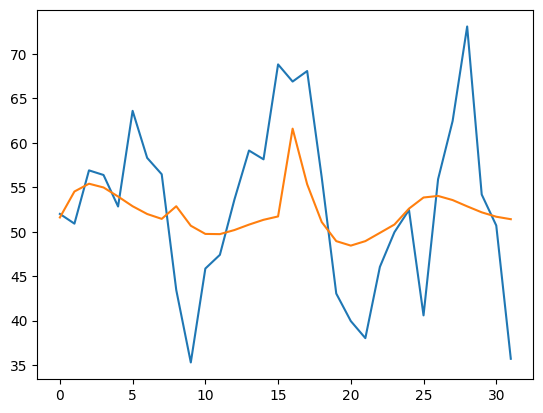

In [190]:
plt.plot(y_test_cA5.flatten())
plt.plot(a5_forecast.flatten())

Métricas de Treinamento para cD1


train_loss    0.735645
valid_loss    0.689362
mae           1.082768
_rmse         1.426836
Name: cD1, dtype: float64

Métricas de Treinamento para cD2


train_loss    0.874363
valid_loss    0.827471
mae           1.244261
_rmse         1.554349
Name: cD2, dtype: float64

Métricas de Treinamento para cD3


train_loss    1.071933
valid_loss    0.987319
mae           1.417327
_rmse         1.776341
Name: cD3, dtype: float64

Métricas de Treinamento para cD4


train_loss    1.557964
valid_loss    1.576688
mae           2.022509
_rmse         2.600835
Name: cD4, dtype: float64

Métricas de Treinamento para cD5


train_loss    2.657810
valid_loss    2.724044
mae           3.168695
_rmse         4.206449
Name: cD5, dtype: float64

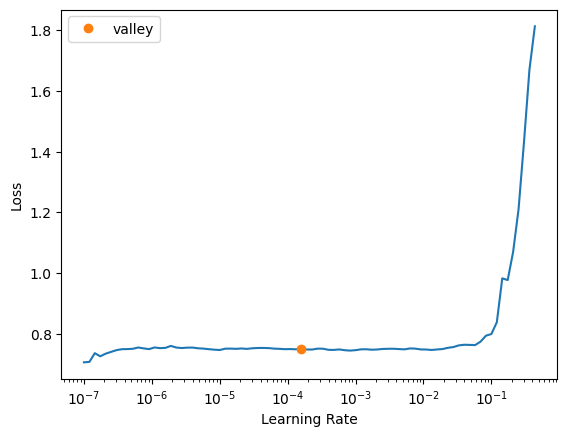

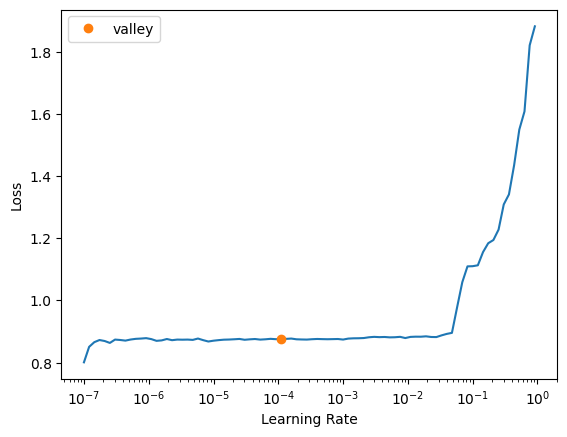

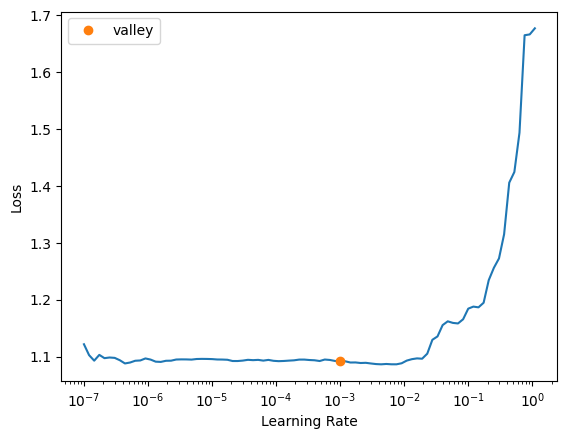

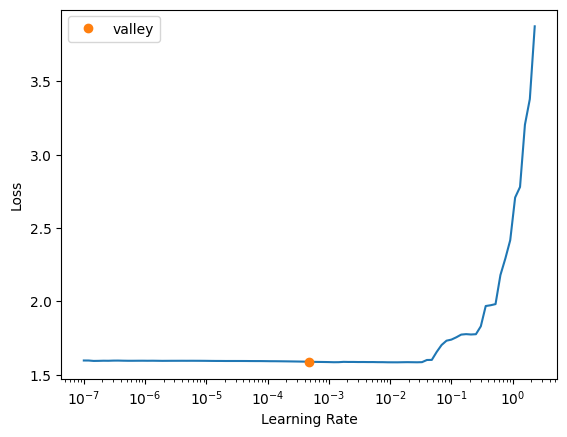

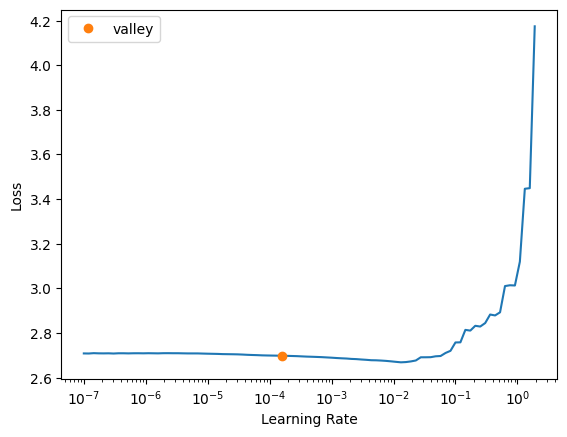

In [123]:
# Prevendo y_test_cD1
forecast_cD1 = forecast_ann(X_train_cD1, y_train_cD1, splits=splits_train_val_cD1, X_test=X_test_cD1, name='cD1', model=TransformerGRUPlus, epochs= 50)

# Prevendo y_test_cD2
forecast_cD2 = forecast_ann(X_train_cD2, y_train_cD2, splits=splits_train_val_cD2, X_test=X_test_cD2, name='cD2', model=TransformerGRUPlus, epochs= 50)

forecast_cD3 = forecast_ann(X_train_cD3, y_train_cD3, splits=splits_train_val_cD3, X_test=X_test_cD3, name='cD3', model=TransformerGRUPlus, epochs= 50)

forecast_cD4 = forecast_ann(X_train_cD4, y_train_cD4, splits=splits_train_val_cD4, X_test=X_test_cD4, name='cD4', model=TransformerGRUPlus, epochs= 50)

forecast_cD5 = forecast_ann(X_train_cD5, y_train_cD5, splits=splits_train_val_cD5, X_test=X_test_cD5, name='cD5', model=TransformerGRUPlus, epochs= 50)

In [124]:
# Revertendo a decomposição
a5_reconstructed = pywt.upcoef('a', cA5_test, 'haar', level=5, take=len(peru_test))
d5_reconstructed = pywt.upcoef('d', cD5_test, 'haar', level=5, take=len(peru_test))
d4_reconstructed = pywt.upcoef('d', cD4_test, 'haar', level=4, take=len(peru_test))
d3_reconstructed = pywt.upcoef('d', cD3_test, 'haar', level=3, take=len(peru_test))
d2_reconstructed = pywt.upcoef('d', cD2_test, 'haar', level=2, take=len(peru_test))
d1_reconstructed = pywt.upcoef('d', cD1_test, 'haar', level=1, take=len(peru_test))

In [185]:
a5_reconstructed_forecast = pywt.upcoef('a', a5_forecast.flatten(), 'haar', level=5, take=len(peru_test))
d5_reconstructed_forecast = pywt.upcoef('d', forecast_cD5.numpy().flatten(), 'haar', level=5, take=len(peru_test))
d4_reconstructed_forecast = pywt.upcoef('d', forecast_cD4.numpy().flatten(), 'haar', level=4, take=len(peru_test))
d3_reconstructed_forecast = pywt.upcoef('d', forecast_cD3.numpy().flatten(), 'haar', level=3, take=len(peru_test))
d2_reconstructed_forecast = pywt.upcoef('d', forecast_cD2.numpy().flatten(), 'haar', level=2, take=len(peru_test))
d1_reconstructed_forecast = pywt.upcoef('d', forecast_cD1.numpy().flatten(), 'haar', level=1, take=len(peru_test))

In [128]:
tamanho_minimo = min(len(a5_reconstructed_forecast), len(d5_reconstructed_forecast), len(d4_reconstructed_forecast), len(d3_reconstructed_forecast), len(d2_reconstructed_forecast), len(d1_reconstructed_forecast))
#? Precisa ser cortado para ter o mesmo tamanho dos outros, a previsão de cada componente pode gerar mais (ou menos) valores do que o necessário

In [129]:
# # Previsão refinada da série temporal original
# # Regressão na matriz de soma Z com produto escalar do coeficiente angular com a matriz Y_hat
# def refined_forecast(Z, Y_hat):
#     model = LinearRegression(fit_intercept=False)
#     model.fit(Z, Y_hat)
#     beta_tilde = model.coef_.T # Coeficientes angulares, transpostos para corresponder ao formato de Y_hat
#     Y_tilde = Z.dot(beta_tilde) # Produto escalar
#     X_tilde = Y_tilde[0, :] # Previsão refinada X = S2 + D2 + D1

#     return X_tilde


# # Matriz de soma Z
# Z = np.array([
#     [1, 1, 1, 1, 1, 1],  # X = S5 + D5 + D4 + D3 + D2 + D1
#     [1, 1, 0, 0, 0, 0],  # S4 = S5 + D5
#     [0, 0, 1, 0, 0, 0],  # D4
#     [1, 1, 1, 0, 0, 0],  # S3 = S5 + D5 + D4
#     [0, 0, 0, 1, 0, 0],  # D3
#     [0, 0, 0, 0, 1, 0],  # D2
#     [0, 0, 0, 0, 0, 1]   # D1
# ])

# # Previsões independentes concatenadas
# Y_hat = np.vstack([
#     a2_reconstructed[:tamanho_minimo] + d2_reconstructed[:tamanho_minimo] + d1_reconstructed[:tamanho_minimo],
#     a2_reconstructed[:tamanho_minimo] + d2_reconstructed[:tamanho_minimo],
#     d1_reconstructed[:tamanho_minimo], 
#     a2_reconstructed[:tamanho_minimo],
#     d2_reconstructed[:tamanho_minimo]
# ])


# # Previsão refinada
# final_forecast = refined_forecast(Z, Y_hat)
# test_values = a2_test[:tamanho_minimo] + d2_test[:tamanho_minimo] + d1_test[:tamanho_minimo]

In [186]:
final_forecast = a5_reconstructed_forecast[:tamanho_minimo] + d5_reconstructed_forecast[:tamanho_minimo] + d4_reconstructed_forecast[:tamanho_minimo] + d3_reconstructed_forecast[:tamanho_minimo] + d2_reconstructed_forecast[:tamanho_minimo] + d1_reconstructed_forecast[:tamanho_minimo]
test_values = a5_reconstructed[:tamanho_minimo] + d5_reconstructed[:tamanho_minimo] + d4_reconstructed[:tamanho_minimo] + d3_reconstructed[:tamanho_minimo] + d2_reconstructed[:tamanho_minimo] + d1_reconstructed[:tamanho_minimo]

2.620569313995748
2.0951972722378494
-26.102392073757475
-0.2615001836496412


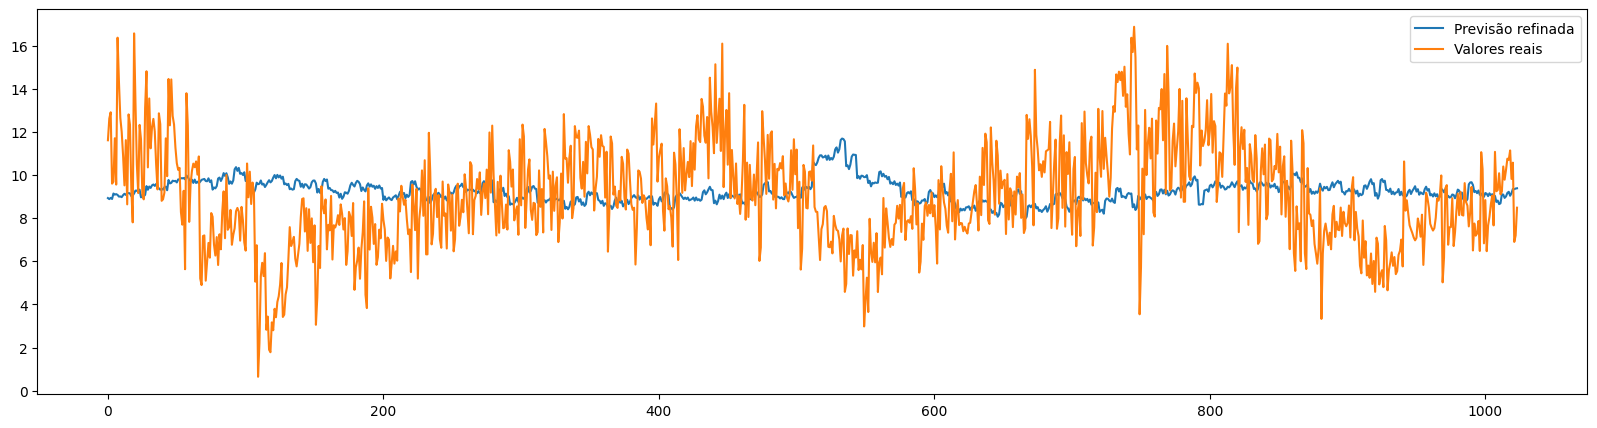

In [187]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(mean_squared_error(final_forecast, test_values,squared=False))
print(mean_absolute_error(final_forecast, test_values))
print(r2_score(final_forecast, test_values))
print(np.corrcoef(final_forecast, test_values)[0, 1])

plt.figure(figsize=(20, 5))
plt.plot(final_forecast)
plt.plot(test_values)
plt.legend(['Previsão refinada', 'Valores reais'])
plt.show()